In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import osmnx  as ox
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# creating the origin from Kissing Students
origin = gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
origin.at[0, 'geometry'] = Point(26.722181, 58.380073)
origin.at[0, 'name'] = 'Kissing students'


In [ ]:
origin.head()

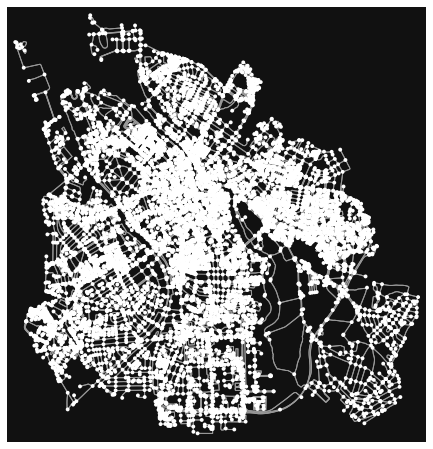

In [3]:
# fetching cafes as the destinations from OSM

# Specify the name that is used to seach for the data
place_name = 'Tartu, Tartu linn, Tartu maakond, Estonia'

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)

# Plot the streets
fig, ax = ox.plot_graph(graph)

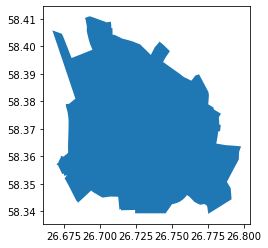

In [4]:
# Get place boundary related to the place name as a geodataframe
area = ox.geocode_to_gdf(place_name)
area.plot();

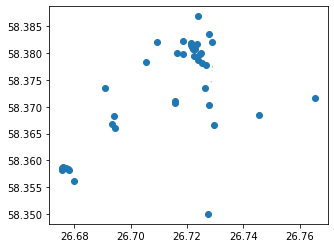

In [7]:
# List key-value pairs for tags
tags = {'amenity': 'cafe'}

# Get the data
cafes = ox.geometries_from_place(place_name, tags)

cafes.plot();

In [17]:
cafes = cafes[['name', 'geometry']]
cafes = cafes.reset_index(drop=True)

# getting centroids from polygons to avoid polygon geometric objects
cafes['geometry'] = [geom.centroid for geom in cafes['geometry']]

print(len(cafes))
cafes.head()

43


,name,geometry
0,Crepp,POINT (26.72126 58.38191)
1,Vaikne Nurgake,POINT (26.72351 58.38165)
2,Illegaard,POINT (26.72241 58.37935)
3,Underground,POINT (26.72271 58.38080)
4,Rotund,POINT (26.71654 58.38002)


In [12]:
# FUNCTION
def shortest_path(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe> crs 4326, network <str> drive, bike, walk
    return shortest path <GeoDataFrame>
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
    
    # Reproject the graph
    graph_proj = ox.project_graph(graph)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph_proj, nodes=False)
    
    # Get CRS info UTM
    CRS = edges.crs
    
    # Reproject all data
    origin_proj = origin.to_crs(crs=CRS)
    destination_proj = destination.to_crs(crs=CRS)
    
    # routes of shortest path
    routes = gpd.GeoDataFrame()
    
    # Get nodes from the graph
    nodes = ox.graph_to_gdfs(graph_proj, edges=False)
    
    # Iterate over origins and destinations
    for oidx, orig in origin_proj.iterrows():
        
        # Find closest node from the graph --> point = (latitude, longitude)
        closest_origin_node = ox.get_nearest_node(G=graph_proj, point=(orig.geometry.y, orig.geometry.x), method='euclidean')
        
        # Iterate over targets
        for tidx, target in destination_proj.iterrows():
            
            # Find closest node from the graph --> point = (latitude, longitude)
            closest_target_node = ox.get_nearest_node(graph_proj, point=(target.geometry.y, target.geometry.x), method='euclidean')

            # Check if origin and target nodes are the same --> if they are --> skip
            if closest_origin_node == closest_target_node:
                print("Same origin and destination node. Skipping ..")
                continue
            
            # Find the shortest path between the points
            route = nx.shortest_path(graph_proj, 
                                     source=closest_origin_node, 
                                     target=closest_target_node, weight='length')
        
            # Extract the nodes of the route
            route_nodes = nodes.loc[route]
        
            # Create a LineString out of the route
            path = LineString(list(route_nodes.geometry.values))
        
            # Append the result into the GeoDataFrame
            routes = routes.append([[path]], ignore_index=True)

    # Add a column name
    routes.columns = ['geometry']        

    # Set geometry
    routes = routes.set_geometry('geometry')
    
    # Set coordinate reference system
    routes.crs = nodes.crs
    
    return routes    


In [18]:
routes = shortest_path(origin, cafes, network = 'walk')

C:\Users\bryan\anaconda3\envs\dev\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


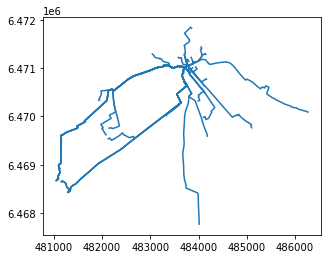

In [19]:
routes.plot();

In [20]:
len(routes)

43

In [21]:
routes.crs

<Projected CRS: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
routes['distance'] = routes['geometry'].length

routes.head()

,geometry,distance
0,"LINESTRING (483750.296 6471036.049, 483780.969...",291.972507
1,"LINESTRING (483750.296 6471036.049, 483780.969...",313.254401
2,"LINESTRING (483750.296 6471036.049, 483726.588...",185.984221
3,"LINESTRING (483750.296 6471036.049, 483780.969...",258.838730
4,"LINESTRING (483750.296 6471036.049, 483726.588...",405.713670


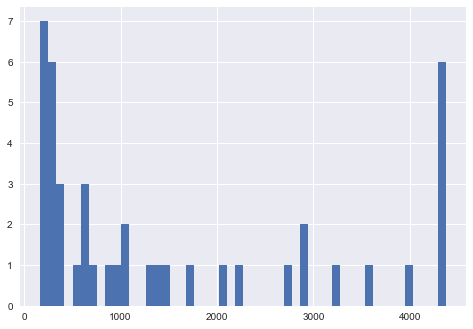

In [43]:
plt.style.use('seaborn')
routes['distance'].hist(bins=50);

In [34]:
routes_wgs = routes.to_crs(4326)

In [35]:
routes_wgs.to_file(r'walking_routes.geojson', driver='GeoJSON')
cafes.to_file(r'cafes_tartu.geojson', driver='GeoJSON')
origin.to_file(r'kissing_students.geojson', driver='GeoJSON')
area.to_file(r'tartu_area.geojson', driver='GeoJSON')

In [25]:
# fetching walking network
def osm_network(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe>, network <str> drive, bike, or walk
    return network <GeoDataFrame>
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph, nodes=False)
    
    return edges

In [27]:
walking_network = osm_network(origin, cafes, network = 'walk')

In [32]:
walking_network = walking_network[['geometry']]
walking_network = walking_network.reset_index(drop=True)

walking_network.head()

,geometry
0,"LINESTRING (26.73016 58.37857, 26.72998 58.378..."
1,"LINESTRING (26.73016 58.37857, 26.73027 58.378..."
2,"LINESTRING (26.73016 58.37857, 26.73003 58.378..."
3,"LINESTRING (26.73056 58.37979, 26.73061 58.379..."
4,"LINESTRING (26.73056 58.37979, 26.73068 58.380..."


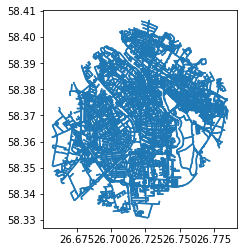

In [29]:
walking_network.plot();

In [33]:
walking_network.to_file(r'walk_network.geojson', driver='GeoJSON')